In [16]:
# ============================================
# 0.   Install / Import Library
# ============================================
# Colab sudah punya pandas, numpy, matplotlib, seaborn, scikit-learn.
# Baris pip di bawah disiapkan bila butuh versi terbaru.
# !pip install --quiet --upgrade pandas matplotlib seaborn scikit-learn joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (r2_score,
                             mean_squared_error,
                             mean_absolute_percentage_error,
                             mean_absolute_error) # Added mean_absolute_error

import joblib
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (10, 5)
sns.set_theme(style="whitegrid")

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/sendhy12/datasetd/refs/heads/main/data_produk_pasar.csv', sep=";")
display(df.head())

,id,satuan,pasar,tanggal,nama_item,keterangan,harga,jumlah,kebutuhan,item_barang,satuan_item,nama_pasar
0,26766,NaN,7,2022-01-01,1,cukup,12000,0,0,Beras Premium,kg,Pasar Parakanmuncang
1,26767,NaN,7,2022-01-01,2,cukup,11500,0,0,Beras Medium,kg,Pasar Parakanmuncang
2,26768,NaN,7,2022-01-01,3,cukup,12000,0,0,Beras Termahal,kg,Pasar Parakanmuncang
3,26769,NaN,7,2022-01-01,4,cukup,14000,0,0,Gula Pasir,kg,Pasar Parakanmuncang
4,26770,NaN,7,2022-01-01,8,cukup,3000,0,0,Minyak Goreng Bimoli,liter,Pasar Parakanmuncang


In [6]:
# ============================================
# 3.   Data Understanding
# ============================================

print('--- 5 baris teratas ---')
display(df.head())

print('\nRingkasan kolom:')
display(df.info())

print('\nStatistik deskriptif harga:')
display(df[['harga']].describe())


--- 5 baris teratas ---


,id,satuan,pasar,tanggal,nama_item,keterangan,harga,jumlah,kebutuhan,item_barang,satuan_item,nama_pasar
0,26766,NaN,7,2022-01-01,1,cukup,12000,0,0,Beras Premium,kg,Pasar Parakanmuncang
1,26767,NaN,7,2022-01-01,2,cukup,11500,0,0,Beras Medium,kg,Pasar Parakanmuncang
2,26768,NaN,7,2022-01-01,3,cukup,12000,0,0,Beras Termahal,kg,Pasar Parakanmuncang
3,26769,NaN,7,2022-01-01,4,cukup,14000,0,0,Gula Pasir,kg,Pasar Parakanmuncang
4,26770,NaN,7,2022-01-01,8,cukup,3000,0,0,Minyak Goreng Bimoli,liter,Pasar Parakanmuncang



Ringkasan kolom:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279723 entries, 0 to 279722
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   id           279723 non-null  int64  
 1   satuan       0 non-null       float64
 2   pasar        279723 non-null  int64  
 3   tanggal      279723 non-null  object 
 4   nama_item    279723 non-null  int64  
 5   keterangan   279723 non-null  object 
 6   harga        279723 non-null  int64  
 7   jumlah       279723 non-null  int64  
 8   kebutuhan    279723 non-null  int64  
 9   item_barang  279723 non-null  object 
 10  satuan_item  279723 non-null  object 
 11  nama_pasar   279723 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 25.6+ MB


None


Statistik deskriptif harga:


,harga
count,2.797230e+05
mean,2.702201e+04
std,2.726870e+04
min,0.000000e+00
25%,1.100000e+04
50%,1.700000e+04
75%,3.600000e+04
max,2.200050e+06


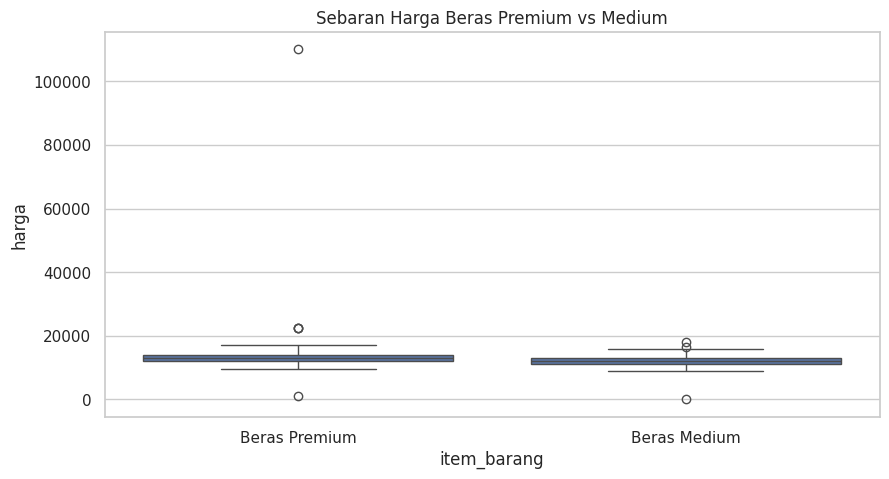

<Figure size 1000x500 with 0 Axes>

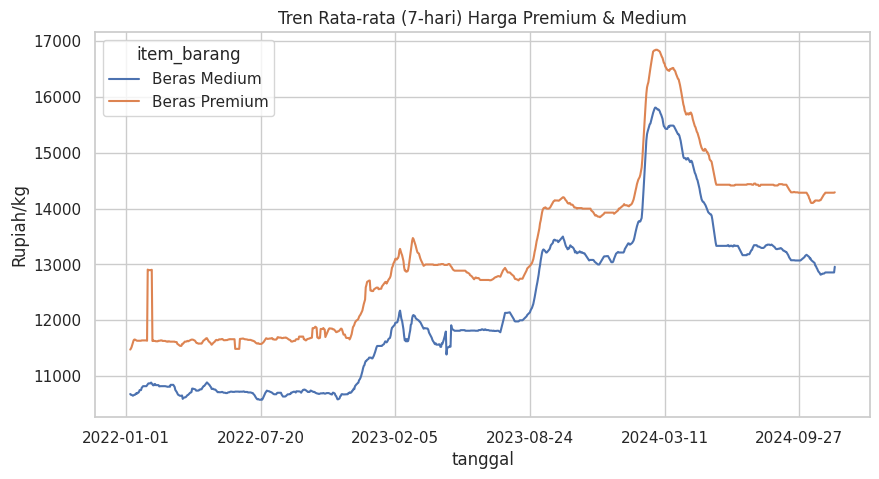

Korelasi Pearson Premium ↔ Medium : 0.970


In [7]:
# ============================================
# 4.   Exploratory Data Analysis (EDA)
# ============================================

# 4.1 Harga Premium vs Medium – Boxplot
plt.figure()
sns.boxplot(x='item_barang', y='harga', data=df[df['item_barang'].isin(['Beras Premium','Beras Medium'])])
plt.title('Sebaran Harga Beras Premium vs Medium')
plt.show()

# 4.2 Pivot untuk lineplot tren (opsional)
pivot_all = (df[df['item_barang'].isin(['Beras Premium','Beras Medium'])]
             .pivot_table(index='tanggal',
                          columns='item_barang',
                          values='harga',
                          aggfunc='mean'))

plt.figure()
pivot_all.rolling(7).mean().plot()
plt.title('Tren Rata-rata (7-hari) Harga Premium & Medium')
plt.ylabel('Rupiah/kg')
plt.show()

# 4.3 Korelasi
corr = pivot_all.corr().iloc[0, 1]
print(f'Korelasi Pearson Premium ↔ Medium : {corr:.3f}')


In [8]:
# ============================================
# 5.   Data Preparation + Cleaning + Outlier
# ============================================

# 5.1 Filter pasar & periode sesuai batasan penelitian
pasar_fokus = ['Pasar Tanjungsari', 'Pasar Conggeang',
               'Pasar Parakanmuncang', 'Pasar Darmaraja']
df = df[df['nama_pasar'].isin(pasar_fokus)]
df = df[df['tanggal'].between('2022-01-01', '2024-12-31')]

# 5.2 Ambil hanya Premium & Medium
df = df[df['item_barang'].isin(['Beras Premium', 'Beras Medium'])]

# 5.3 Perbaikan typo harga (ex: harga < 1000 atau > 100000 → dianggap salah ketik)
df = df[(df['harga'] >= 1000) & (df['harga'] <= 100000)]

# 5.4 Tangani duplikat (ambil rata-rata per (tanggal, pasar, item_barang))
df = (df.groupby(['tanggal','nama_pasar','item_barang'], as_index=False)
        .agg({'harga':'mean'}))

# 5.5 Pivot sehingga 1 baris = (tanggal, pasar) & 2 kolom harga
df_pivot = (df.pivot_table(index=['tanggal','nama_pasar'],
                            columns='item_barang',
                            values='harga')
              .reset_index()
              .dropna())

# 5.6 Penanganan outlier dengan IQR (Beras Premium & Medium)
def remove_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[col] >= lower) & (df[col] <= upper)]

# Terapkan untuk kedua kolom harga
df_pivot = remove_outliers_iqr(df_pivot, 'Beras Premium')
df_pivot = remove_outliers_iqr(df_pivot, 'Beras Medium')

# 5.7 X & y
X = df_pivot[['Beras Premium']]
y = df_pivot['Beras Medium']

print('Ukuran dataset akhir:', df_pivot.shape)
df_pivot.head()


Ukuran dataset akhir: (4114, 4)


item_barang,tanggal,nama_pasar,Beras Medium,Beras Premium
0,2022-01-01,Pasar Conggeang,11000.0,12000.0
1,2022-01-01,Pasar Darmaraja,10000.0,9500.0
2,2022-01-01,Pasar Parakanmuncang,11500.0,12000.0
3,2022-01-02,Pasar Conggeang,11000.0,12000.0
4,2022-01-02,Pasar Darmaraja,10000.0,9500.0


In [9]:
# ============================================
# 6.   Modeling  (Linear Regression)
# ============================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, shuffle=True
)

model = LinearRegression()
model.fit(X_train, y_train)

print(f'Persamaan regresi:  y = {model.intercept_:.2f}  +  {model.coef_[0]:.3f} × X')


Persamaan regresi:  y = -191.83  +  0.946 × X


R²   : 0.948
RMSE : 326.05 rupiah
MAPE : 2.00%


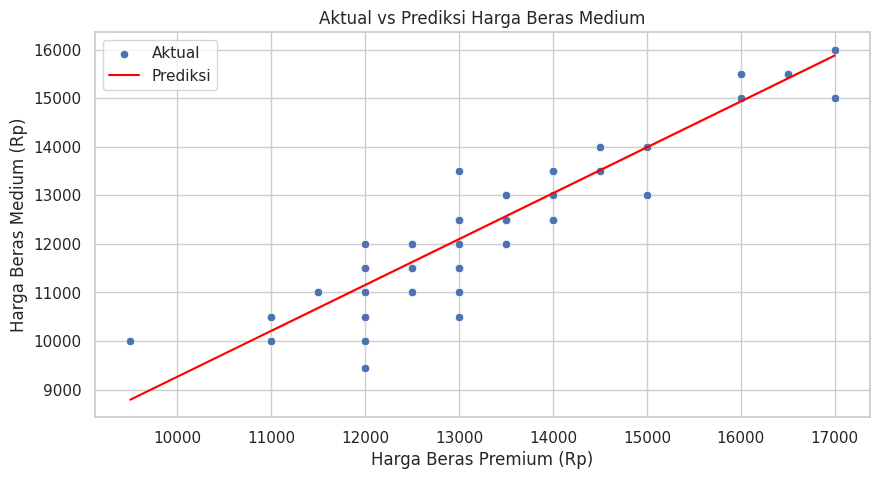

In [10]:
# ============================================
# 7.   Evaluation
# ============================================
y_pred = model.predict(X_test)

r2   = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print(f'R²   : {r2:.3f}')
print(f'RMSE : {rmse:.2f} rupiah')
print(f'MAPE : {mape:.2f}%')

# Scatter plot + regresi
plt.figure()
sns.scatterplot(x=X_test['Beras Premium'], y=y_test, label='Aktual')
sns.lineplot(x=X_test['Beras Premium'], y=y_pred, color='red', label='Prediksi')
plt.title('Aktual vs Prediksi Harga Beras Medium')
plt.xlabel('Harga Beras Premium (Rp)')
plt.ylabel('Harga Beras Medium (Rp)')
plt.legend()
plt.show()


In [17]:
# prompt: mae

print(f'MAE  : {mean_absolute_error(y_test, y_pred):.2f} rupiah')

MAE  : 236.91 rupiah


In [11]:
# ============================================
# 8.   Simpan Model (opsional, untuk deployment)
# ============================================
joblib.dump(model, 'model_regresi_beras.pkl')
print('Model disimpan → model_regresi_beras.pkl')


Model disimpan → model_regresi_beras.pkl


In [14]:
# ============================================
# 9.   Prediksi Harga Medium Baru (contoh)
# ============================================
harga_premium_baru = 12000  # contoh input
prediksi_medium = model.predict([[harga_premium_baru]])[0]
print(f'Jika harga Premium = Rp {harga_premium_baru:,}, prediksi harga Medium ≈ Rp {prediksi_medium:,.0f}')


Jika harga Premium = Rp 12,000, prediksi harga Medium ≈ Rp 11,155
